In [1]:
import GACF
from GACF.datastructure import DataStructure
from GACF.correlator import CorrelationIterator, Correlator
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv

In [2]:
dir(GACF)

['BadDataFileReadException',
 'EmptyDataStructureException',
 'GACF',
 'GACF_LOG_MESSAGE',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 'correlator',
 'datastructure',
 'find_correlation_from_file',
 'find_correlation_from_lists']

In [3]:
def find_correlation(corr, selection_function='natural', weight_function='fractional', only_positive=False):
    
    def lag_generator(max_lag, lag_resolution):
        k = 0 if only_positive else -max_lag
        while (k <= max_lag):
            yield k
            k += lag_resolution

    num_steps = corr.num_lag_timesteps

    for i, k in enumerate(tqdm(lag_generator(corr.max_lag, corr.lag_resolution),
                               desc='Calculating correlations',
                               total=num_steps * (1. if only_positive else 2.))):
#         print i, k, "\r"
        col_it = CorrelationIterator(k, corr.N_datasets)
        SELECTION_FUNCTIONS[selection_function](corr, col_it)
        corr.deltaT(col_it)
        WEIGHT_FUNCTIONS[weight_function](corr, col_it)
        corr.findCorrelation(col_it)
        corr.addCorrelationData(col_it, i)

    return corr

In [4]:
def find_correlation_from_lists(timeseries, values, errors=None, max_lag=None, lag_resolution=None,
                                selection_function='natural', weight_function='fractional', alpha=None, 
                                only_positive=False):
    """
    :param timeseries: list of time values
    :param values: list of X values
    :param errors: (optional) list of errors on X values
    :param max_lag: max lag in days
    :param lag_resolution: lag resolution in days
    :param selection_function: 'fast' or 'natural' - see paper for more details
    :param weight_function: 'gaussian' or 'fractional' see paper for more details
    :param alpha: weight function characteristic length scale, default is t.median_time
    :return: { 'lag_timeseries':[], 'correlations':[] }, Correlator
    """
    if errors is None:
        ds = DataStructure(timeseries, values)
    else:
        ds = DataStructure(timeseries, values, errors)

    return return_correlations_from_datastructure(ds, max_lag, lag_resolution, selection_function, weight_function, alpha,
                                                  only_positive=only_positive)

In [5]:
def return_correlations_from_datastructure(ds, max_lag, lag_resolution, selection_function, weight_function, alpha, 
                                           only_positive=False):
    
    corr = Correlator(ds)

    corr = set_up_correlation(corr, max_lag, lag_resolution, alpha)
    corr = find_correlation(corr, selection_function, weight_function, only_positive=only_positive)
    N_datasets = corr.N_datasets
    lag_timeseries = corr.lag_timeseries
    correlations = corr.correlations

    return {'lag_timeseries': lag_timeseries, 'correlations': (correlations if N_datasets > 1. else correlations[0])}, corr

In [6]:
def set_up_correlation(corr, max_lag=None, lag_resolution=None, alpha=None):
    """ Returns Correlator object. Applies non-default values to Correlator """
    if max_lag is not None:
        corr.max_lag = max_lag
    if lag_resolution is not None:
        corr.lag_resolution = lag_resolution
    if alpha is not None:
        corr.alpha = alpha
    return corr

In [7]:
SELECTION_FUNCTIONS = {
    'fast': Correlator.fastSelectionFunctionIdx,
    'natural': Correlator.naturalSelectionFunctionIdx
}

WEIGHT_FUNCTIONS = {
    'gaussian': Correlator.getGaussianWeights,
    'fractional': Correlator.getFractionWeights
}

In [8]:
def get_data_from_file(filename):
    ds = DataStructure(filename)
    if ds.N_datasets == 1:
        data = ds.data()[0]
        errors = ds.errors()[0]
    else:
        data = ds.data()
        errors = ds.errors()
    return ds.timeseries(), data, errors

In [9]:
timeseries = np.array(read_csv('irregular_sampling.txt', dtype=np.float64, sep='\s+')['#'])
timeseries_regular = np.array(read_csv('regular_sampling.txt', dtype=np.float64, sep='\s+')['#'])
timeseries_random = np.array(read_csv('random_sampling.txt', dtype=np.float64, sep='\s+')['#'])
# print timeseries
    
flux = np.sin(timeseries * (2.0 * np.pi / 25.0))
flux_regular = np.sin(timeseries_regular * (2.0 * np.pi / 25.0))
flux_random = np.sin(timeseries_random * (2.0 * np.pi / 25.0))


correlations1, _ = find_correlation_from_lists(timeseries, flux)
correlations2, _ = find_correlation_from_lists(timeseries, flux, only_positive=True)

correlations1_regular, _ = find_correlation_from_lists(timeseries_regular, flux_regular)
correlations2_regular, _ = find_correlation_from_lists(timeseries_regular, flux_regular, only_positive=True)

correlations1_random, _ = find_correlation_from_lists(timeseries_random, flux_random)
correlations2_random, _ = find_correlation_from_lists(timeseries_random, flux_random, only_positive=True)

Calculating correlations: 100%|█████████▉| 1001/1002.0 [00:00<00:00, 4086.83it/s]
Calculating correlations: 100%|██████████| 501/501.0 [00:00<00:00, 5553.23it/s]
Calculating correlations: 100%|█████████▉| 1001/1002.0 [00:00<00:00, 4081.09it/s]
Calculating correlations: 100%|██████████| 501/501.0 [00:00<00:00, 5257.41it/s]
Calculating correlations: 100%|█████████▉| 1000/1002.0 [00:00<00:00, 3547.31it/s]
Calculating correlations: 100%|█████████▉| 500/501.0 [00:00<00:00, 5442.23it/s]


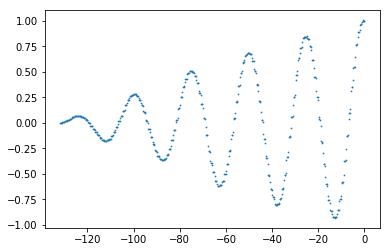

In [10]:
plt.scatter(correlations1['lag_timeseries'], correlations1['correlations'], s=0.5)
plt.show()

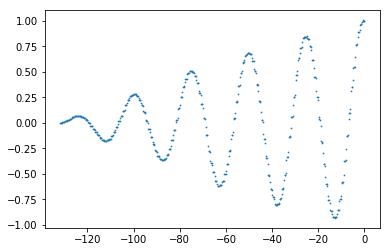

In [11]:
plt.scatter(correlations1['lag_timeseries'], correlations1['correlations'], s=0.5)
plt.show()

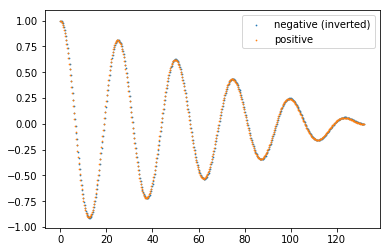

In [16]:
plt.scatter(0. - np.array((correlations1_regular['lag_timeseries'])), correlations1_regular['correlations'], s=0.5, label='negative (inverted)')
plt.scatter(correlations2_regular['lag_timeseries'], correlations2_regular['correlations'], s=0.5, label='positive')
plt.legend()
plt.show()

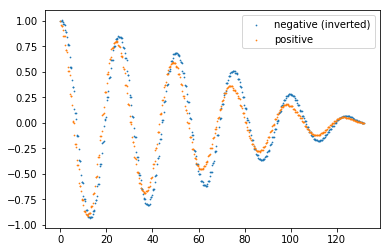

In [37]:
plt.scatter(0. - np.array((correlations1['lag_timeseries'])), correlations1['correlations'], s=0.5, label='negative (inverted)')
plt.scatter(correlations2['lag_timeseries'], correlations2['correlations'], s=0.5, label='positive')
plt.legend()
plt.show()

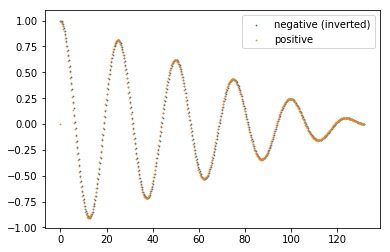

In [18]:
plt.scatter(0. - np.array((correlations1_random['lag_timeseries'])), correlations1_random['correlations'], s=0.5, label='negative (inverted)')
plt.scatter(correlations2_random['lag_timeseries'], correlations2_random['correlations'], s=0.5, label='positive')
plt.legend()
plt.show()

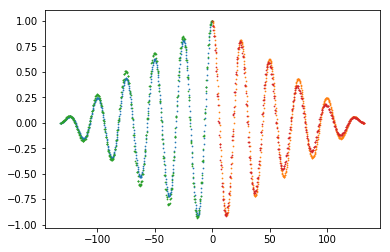

In [15]:
plt.scatter(correlations1_regular['lag_timeseries'], correlations1_regular['correlations'], s=0.5)
plt.scatter(correlations2_regular['lag_timeseries'], correlations2_regular['correlations'], s=0.5)
plt.scatter(correlations1['lag_timeseries'], correlations1['correlations'], s=0.5)
plt.scatter(correlations2['lag_timeseries'], correlations2['correlations'], s=0.5)

plt.show()

In [19]:
import sys
sys.path.append('/home/jtb34/GitHub/GACF')
from NGTS.NGTS_Field import NGTSField as NF
from NGTS.NGTS_Object import NGTSObject as NO

In [38]:
# force time series into NGTS object to allow use of methods
preg_obj = NO('positive_regular', None, None)
nreg_obj = NO('negative_regular', None, None)

preg_obj.timeseries_binned = timeseries_regular
nreg_obj.timeseries_binned = timeseries_regular
preg_obj.flux_binned = flux_regular
nreg_obj.flux_binned = flux_regular
preg_obj.correlations = correlations2_regular['correlations']
nreg_obj.correlations = correlations1_regular['correlations']
preg_obj.lag_timeseries = correlations2_regular['lag_timeseries']
nreg_obj.lag_timeseries = np.array((correlations1_regular['lag_timeseries']))


prand_obj = NO('positive_random', None, None)
nrand_obj = NO('negative_random', None, None)

prand_obj.timeseries_binned = timeseries_random
nrand_obj.timeseries_binned = timeseries_random
prand_obj.flux_binned = flux_random
nrand_obj.flux_binned = flux_random
prand_obj.correlations = correlations2_random['correlations']
nrand_obj.correlations = correlations1_random['correlations']
prand_obj.lag_timeseries = correlations2_random['lag_timeseries']
nrand_obj.lag_timeseries = np.array((correlations1_random['lag_timeseries']))

pirr_obj = NO('positive_irregular', None, None)
nirr_obj = NO('negative_irregular', None, None)

pirr_obj.timeseries_binned = timeseries
nirr_obj.timeseries_binned = timeseries
pirr_obj.flux_binned = flux
nirr_obj.flux_binned = flux
pirr_obj.correlations = correlations2['correlations']
nirr_obj.correlations = correlations1['correlations']
pirr_obj.lag_timeseries = correlations2['lag_timeseries']
nirr_obj.lag_timeseries = np.array((correlations1['lag_timeseries']))

objs = [preg_obj, nreg_obj, prand_obj, nrand_obj, pirr_obj, nirr_obj]

In [39]:
for obj in objs:
    obj.calculate_periods_from_autocorrelation()

positive_regular, period(s) found [24.027762332727274]


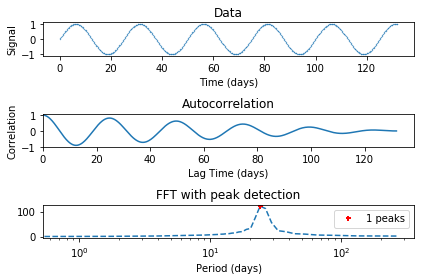

negative_regular, period(s) found [24.02776233272812]


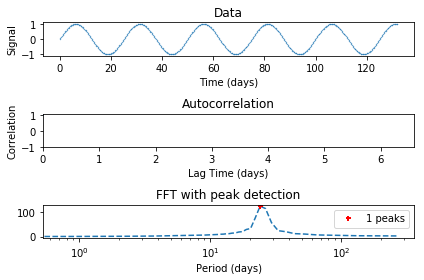

positive_random, period(s) found [24.006021929800358]


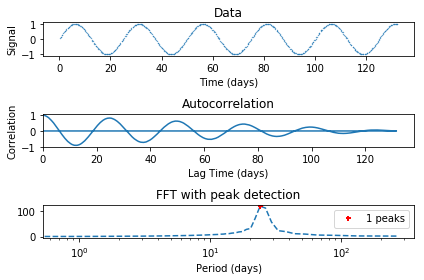

negative_random, period(s) found [24.006021929799644]


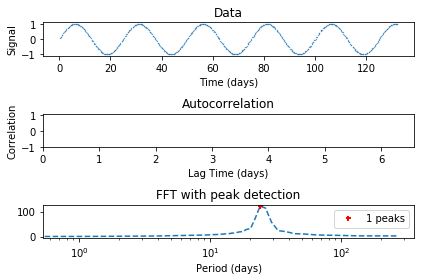

positive_irregular, period(s) found [24.027762332727274]


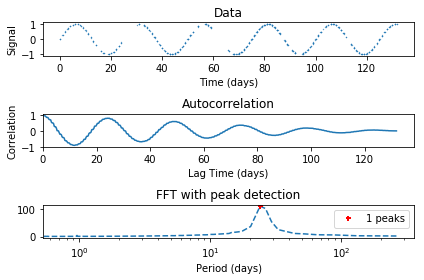

negative_irregular, period(s) found [24.02776233272812]


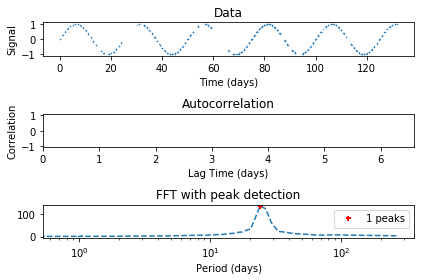

In [40]:
for obj in objs:
    print "{}, period(s) found {}".format(obj.obj, obj.periods)
    obj.plot_data_autocol_ft(interactive=True)